In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import einops
import torch.nn.functional as F
from torch.utils.data import DataLoader


import matplotlib.pyplot as plt
import seaborn as sns

from src.models.vfm_wrapper import CatFlow
from src.models.base_models import ToyModel


In [2]:
train_size = 512_000//8
D = 8
batch_size = 1024
num_classes = 5
p0 = torch.distributions.MultivariateNormal(torch.zeros(num_classes), torch.eye(num_classes))
p1 = torch.distributions.Dirichlet(torch.ones(num_classes))

target_distribution = p1.sample((D,))
train_data = torch.distributions.Categorical(target_distribution).sample((train_size,))

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

In [3]:
model = ToyModel(num_classes)
catflow = CatFlow(model, obs_dim=(D, ), p0=p0)

In [4]:
optimizer = torch.optim.AdamW(catflow.parameters(), lr=1e-4)

In [5]:
total_loss = []
from tqdm import tqdm
pbar = tqdm(range(50), desc='Training: ')
for epoch in pbar:
    epoch_loss = 0.0
    for x1 in train_loader:
        batch_size, D = x1.shape
        x0 = catflow.p0.sample((batch_size, D))
        t = torch.rand((batch_size,))
        loss = catflow.criterion(t, x0, x1)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    total_loss.append(epoch_loss/len(train_loader))
    pbar.set_postfix({'Loss':total_loss[-1]})

Training: 100%|██████████| 50/50 [06:41<00:00,  8.03s/it, Loss=6.4] 


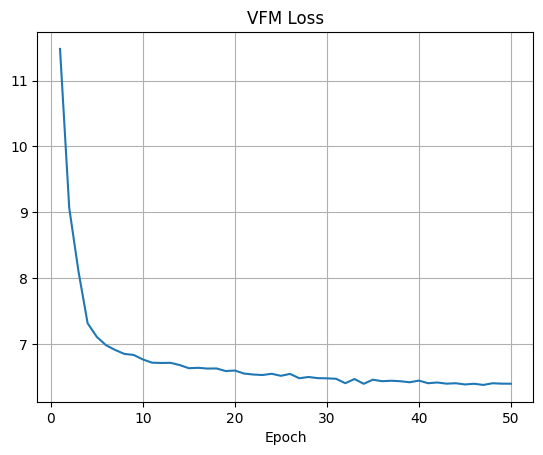

In [6]:
import matplotlib.pyplot as plt
plt.title("VFM Loss")
plt.plot(torch.arange(1, len(total_loss)+1), total_loss)
plt.xlabel("Epoch")
plt.grid();

In [7]:
samples = []
for i, x1 in tqdm(enumerate(train_loader)):
    sample = catflow.sample(x1.shape[0])
    samples.append(sample)
    if i >= 10: break

samples = torch.cat(samples, dim=0)

10it [02:18, 13.84s/it]


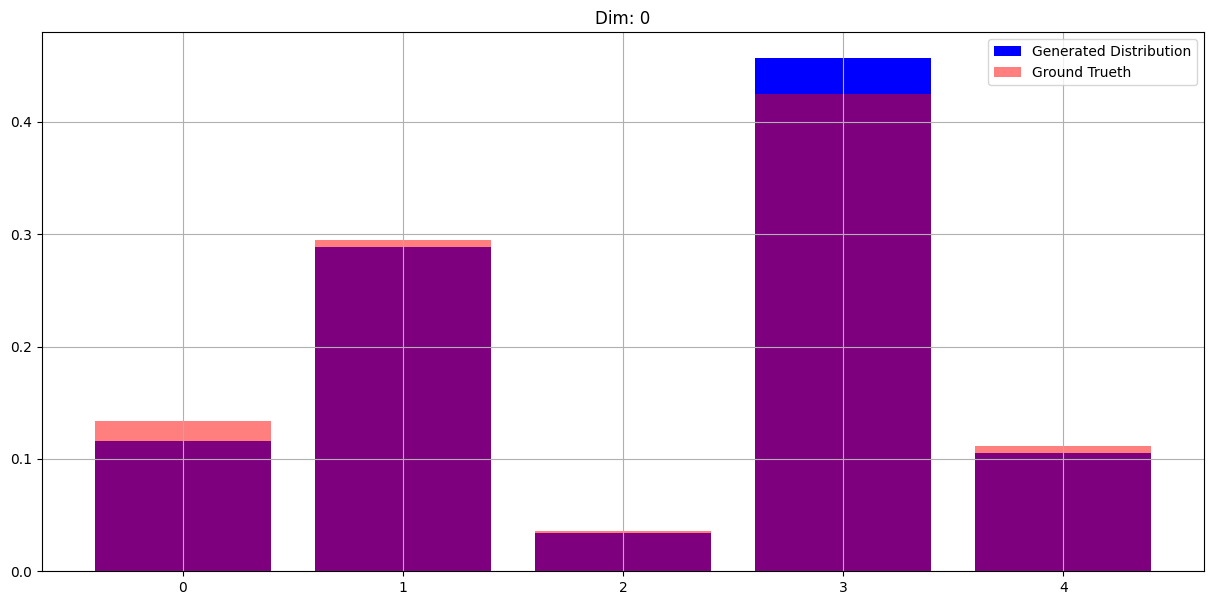

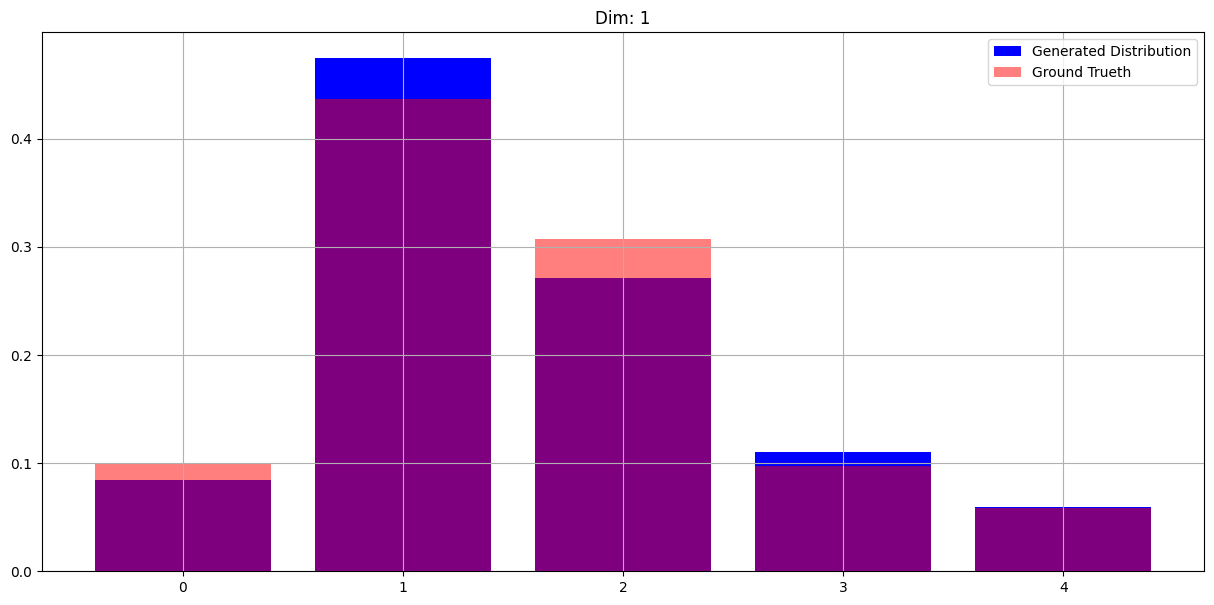

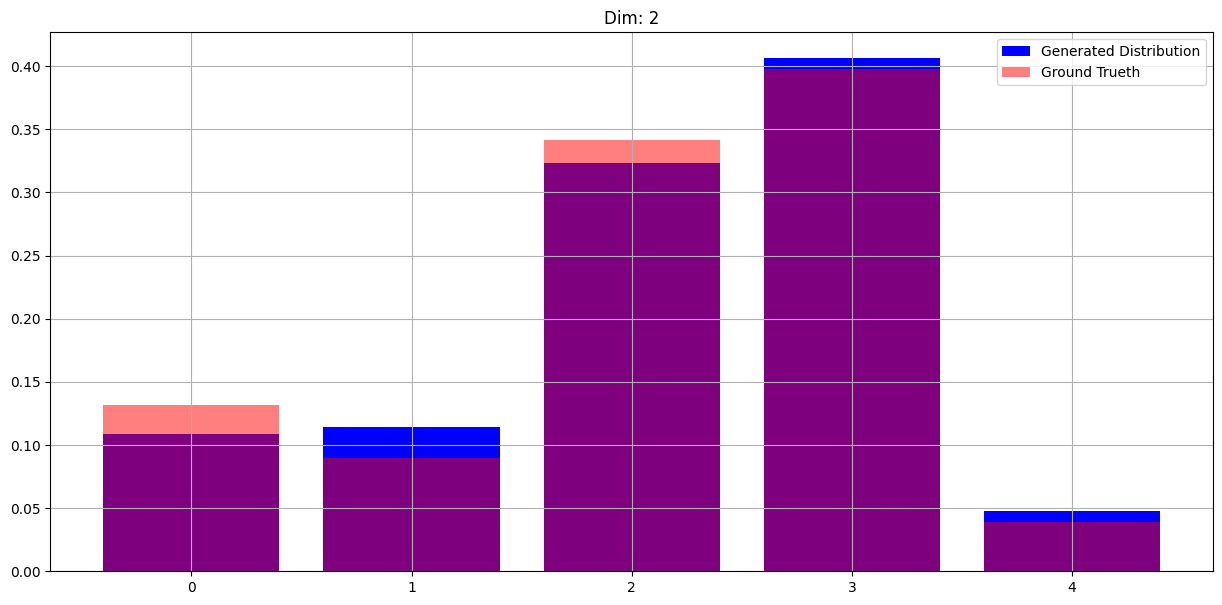

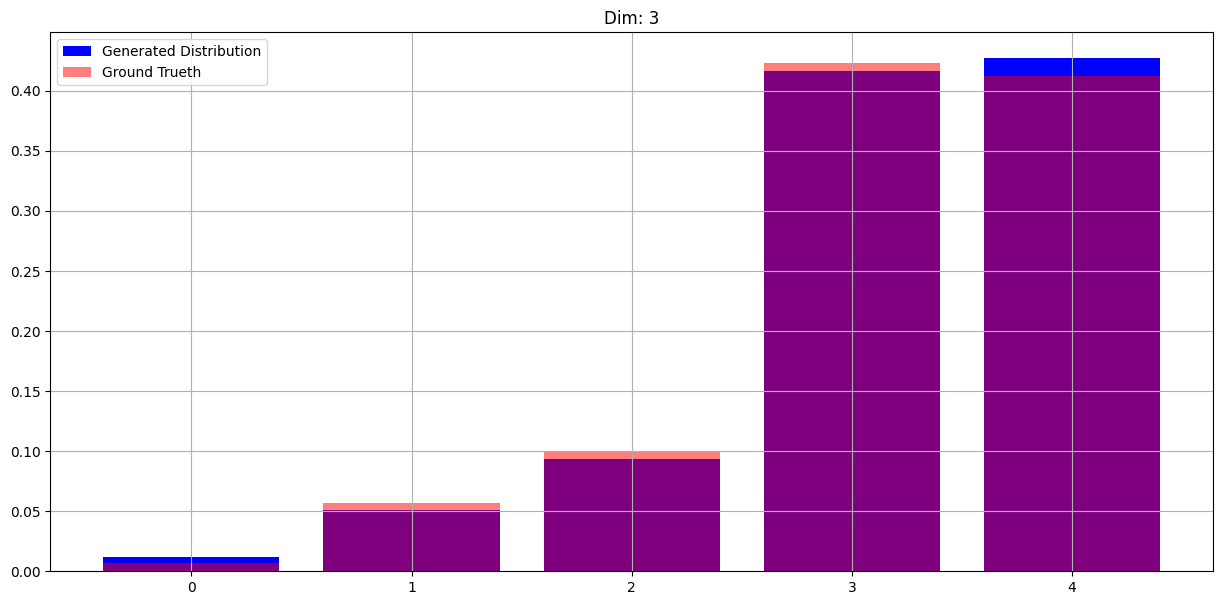

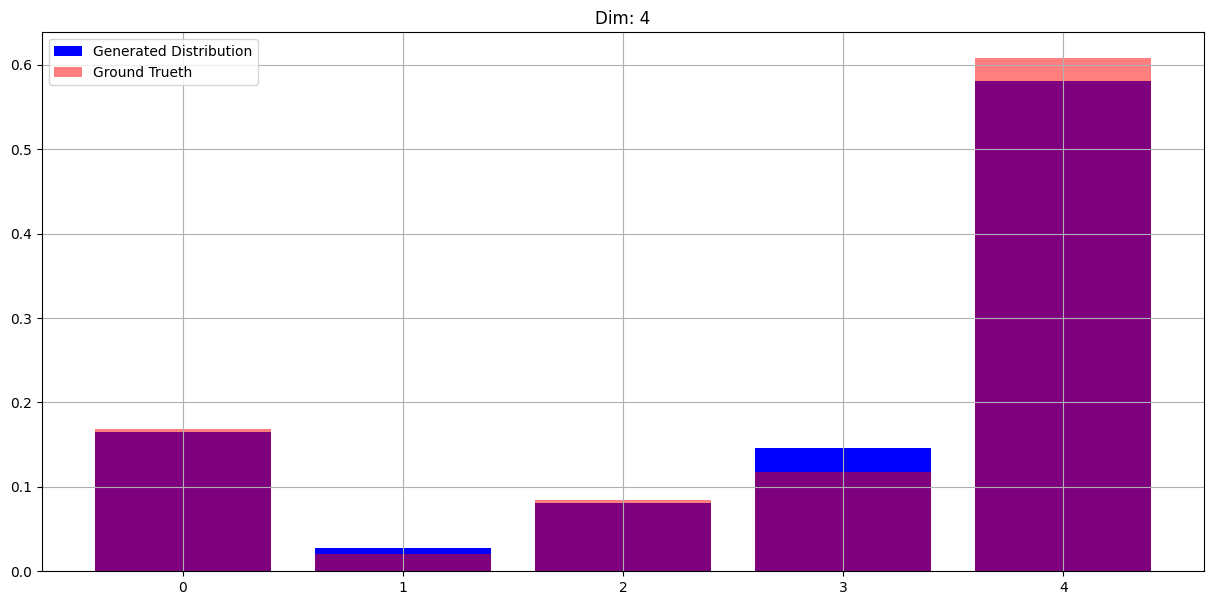

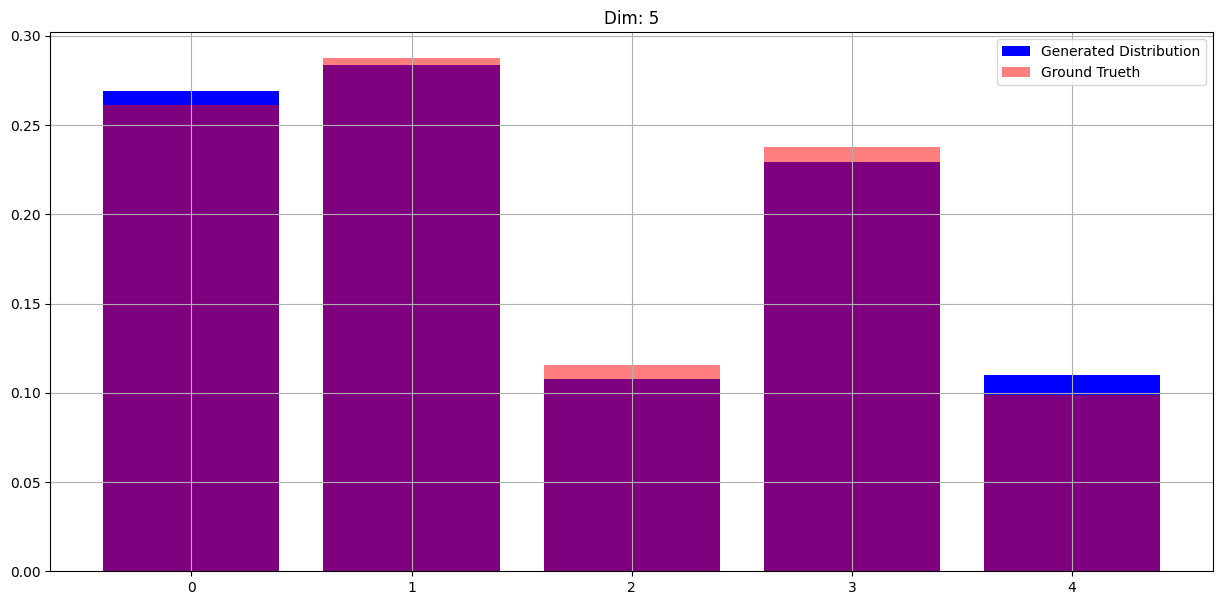

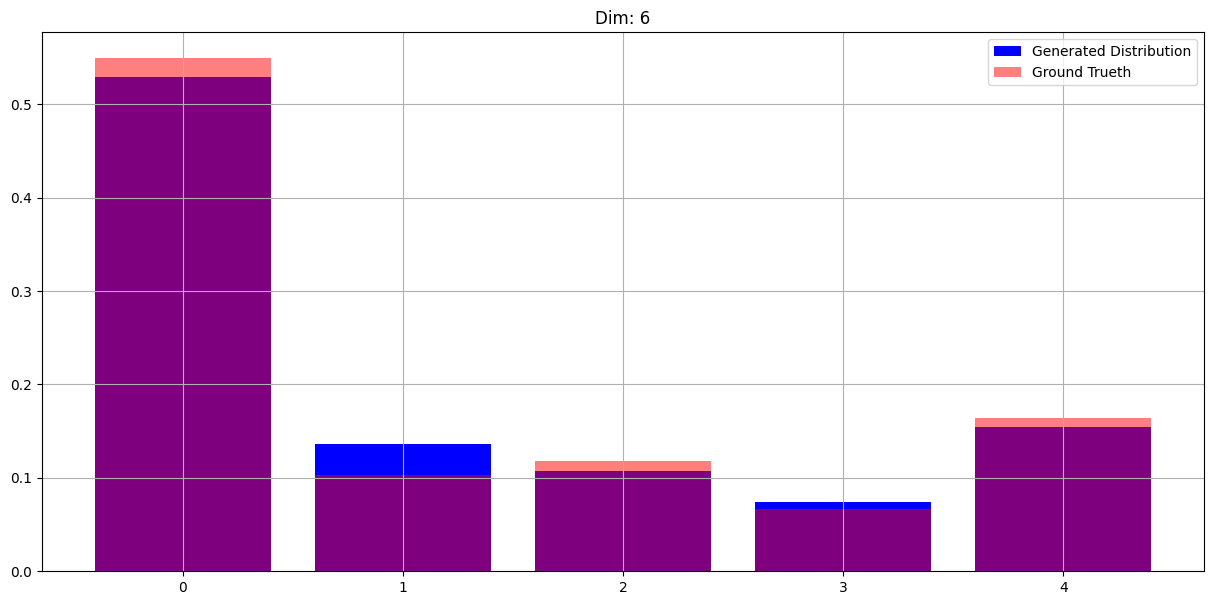

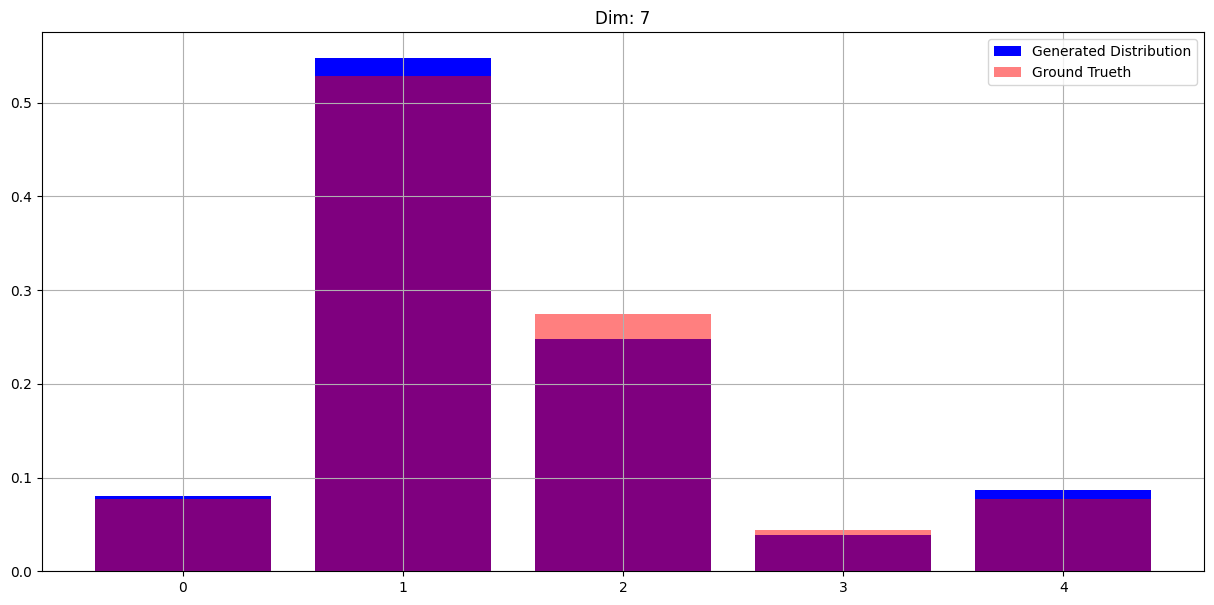

In [8]:
for d in range(D):
    empirical = torch.mean((samples[:, d, None].argmax(-1) == torch.arange(num_classes)).float(), dim=0)
    plt.figure(figsize=(15, 7))
    plt.title(f'Dim: {d}')
    plt.bar(torch.arange(num_classes), empirical, color='b')
    plt.bar(torch.arange(num_classes), target_distribution[d], alpha=0.5, color='r')
    plt.legend(['Generated Distribution', 'Ground Trueth'])
    plt.grid()